In [1]:

import numpy as np
import torch
import matplotlib.pyplot as plt


import os
from models import TransformerModel, ChebyshevKernelLeastSquaresModel
from tasks import get_task_sampler, ClampedChebyshev, ChebyshevKernelLinearRegression
from samplers import get_data_sampler
import torch
import numpy as np
import matplotlib.pyplot as plt
from models import *
from samplers import *
import yaml
from types import SimpleNamespace
from tqdm import tqdm

from interpretability import *

torch.set_num_threads(4)  # Set this to the number of threads you want
torch.set_num_interop_threads(4)
GPU = 3
device = torch.device(f"cuda:{GPU}")


/home/dylandavis/.conda/envs/in-context-learning/lib/python3.8/site-packages/scipy/__init__.py:143: UserWarning: A NumPy version >=1.19.5 and <1.27.0 is required for this version of SciPy (detected version 1.19.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
base_model_path =  "../models/finetune_chebyshev_standard_clamped_loss/first_finetune_run"#../models/eval_ckpts/c3b57089-5466-4a2d-a9a7-d82eff45732a/"#'/home/riadoshi/alignment/Alignment/models/train_multiple/c3b57089-5466-4a2d-a9a7-d82eff45732a/'
config_path = os.path.join(base_model_path, "config.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)

def dict_to_namespace(d):
    if isinstance(d, dict):
        return SimpleNamespace(**{k: dict_to_namespace(v) for k, v in d.items()})
    return d
config = dict_to_namespace(config)

base_model = build_model(config.model)
base_model.to(device)

state_path = os.path.join(base_model_path, "model_250000.pt")
state = torch.load(state_path, map_location=device)
base_model.load_state_dict(state)

#finetuned_model_path = "../models/finetuned123"
#finetuned_model = get_model(finetuned_model_path, n_embd=128, n_layer=6, n_head=4)

<All keys matched successfully>

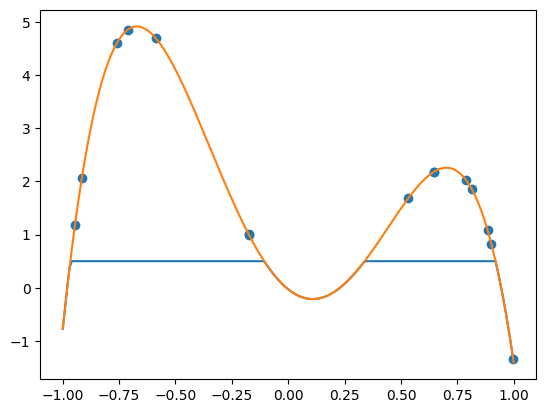

In [3]:
sampler = UniformSampler(n_dims=1)

clamped_task = ClampedChebyshev(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
orig_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)

chebyshev_model = ChebyshevKernelLeastSquaresModel(basis_dim=11)

num_xs_to_pred = 200

#xs_context = sampler.sample_xs(255, 1)
xs_context = sampler.sample_xs(15, 1)
#xs_to_pred = sampler.sample_xs(num_xs_to_pred, 1)
xs_to_pred = torch.linspace(-1, 1, num_xs_to_pred).view(1,200,1)



#ys_clamped_context = clamped_task.evaluate(xs_context, noise=False, separate_noise=False)
#ys_clamped_to_pred = clamped_task.evaluate(xs_to_pred, noise=False, separate_noise=False)
ys_unclamped_context = orig_task.evaluate(xs_context, noise=False, separate_noise=False)
ys_unclamped_to_pred = orig_task.evaluate(xs_to_pred, noise=False, separate_noise=False)

ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

xs_gt, ys_gt = torch.concat((xs_context.squeeze(), xs_to_pred.squeeze())), torch.concat((ys_clamped_context.squeeze(), ys_clamped_to_pred.squeeze()))

# # plot the grount truth clamped polynomial
plt.plot(xs_to_pred.squeeze(), ys_clamped_to_pred.squeeze())
plt.plot(xs_to_pred.squeeze(), ys_unclamped_to_pred.squeeze())
plt.scatter(xs_context.squeeze(), ys_unclamped_context.squeeze())

torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 16, 12])
torch.Size([1, 1

Text(0.5, 1.0, 'Base Model: Degree 4 Clamping From Context')

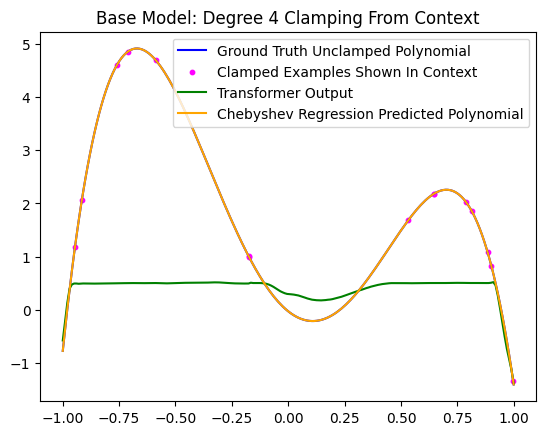

In [4]:
predicted_ys_on_context = []
chebyshev_predicted = []
xs_to_pred = xs_to_pred.squeeze()
xs_context = xs_context.squeeze()
ys_unclamped_context = ys_unclamped_context.squeeze()
ys_unclamped_to_pred = ys_unclamped_to_pred.squeeze()

ys_clamped_context = ys_clamped_context.squeeze()
ys_clamped_to_pred = ys_clamped_to_pred.squeeze()

for i in range(0, num_xs_to_pred):
    xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]])))
    ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]])))

    xs = xs.unsqueeze(0)    
    xs = xs.unsqueeze(-1)  

    ys = ys.unsqueeze(0)

    xs = xs.to(device)
    ys = ys.to(device)

    pred = base_model(xs, ys).detach().cpu()
    predicted_ys_on_context.append(pred.squeeze()[-1])

    chebyshev_pred = chebyshev_model(xs,ys)
    chebyshev_predicted.append(chebyshev_pred.squeeze()[-1])


plt.plot(xs_to_pred.squeeze(), ys_unclamped_to_pred.squeeze(), label="Ground Truth Unclamped Polynomial", color="blue")
plt.scatter(xs_context.squeeze(), ys_unclamped_context.squeeze(), label="Clamped Examples Shown In Context", color="fuchsia",marker='o', s=10)
plt.plot(xs_to_pred.squeeze(), predicted_ys_on_context, label="Transformer Output", color="green")
plt.plot(xs_to_pred.squeeze(), chebyshev_predicted, label="Chebyshev Regression Predicted Polynomial", color="orange")

plt.legend()
plt.title("Base Model: Degree 4 Clamping From Context")

In [3]:
num_tasks = 1000
context_size = 25

num_predictions = 5

sampler = UniformSampler(n_dims=1)

recorder_unclamped = ActivationRecorder()
recorder_clamped = ActivationRecorder()

hooks_clamped = register_residual_hooks(base_model, recorder_clamped)
# Collect Refusal activations
for _ in tqdm(range(num_tasks)):

    chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)

    xs_context = sampler.sample_xs(context_size, 1)
    xs_to_pred = sampler.sample_xs(num_predictions, 1)

    ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).squeeze()
    ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).squeeze()

    ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
    ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

    xs_context = xs_context.squeeze()
    xs_to_pred = xs_to_pred.squeeze()

    for i in range(0, num_predictions):
        
        # only look at examples that are being reused (leave a little room for numerical uncertainty)
        if ys_unclamped_to_pred[i] > 0.6:
            continue

        xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]]))).view(1,26,1).to(device)
        ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]]))).view(1,26).to(device)

        _ = base_model(xs, ys).detach().cpu()

clear_hooks(hooks_clamped)        

hooks_unclamped = register_residual_hooks(base_model, recorder_unclamped)
# Collect Refusal activations
for _ in tqdm(range(num_tasks)):

    chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)

    xs_context = sampler.sample_xs(context_size, 1)
    xs_to_pred = sampler.sample_xs(num_predictions, 1)

    ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).squeeze()
    ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).squeeze()

    ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
    ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

    xs_context = xs_context.squeeze()
    xs_to_pred = xs_to_pred.squeeze()

    for i in range(0, num_predictions):
        
        # only look at examples that are not being reused (leave a little room for numerical uncertainty)
        if ys_unclamped_to_pred[i] < 0.4:
            continue

        xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]]))).view(1,26,1).to(device)
        ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]]))).view(1,26).to(device)

        _ = base_model(xs, ys).detach().cpu()

clear_hooks(hooks_unclamped)        
    

100%|██████████| 1000/1000 [00:07<00:00, 140.17it/s]


In [4]:
mean_clamped = recorder_clamped.get_mean_activations()
mean_unclamped = recorder_unclamped.get_mean_activations()

# Compute difference-in-means per layer
diff_vectors = {
    layer: mean_unclamped[layer] - mean_clamped[layer]
    for layer in mean_clamped
}

refusal_vector = {
    layer: diff.mean(dim=(0, 1))  # mean over batch & sequence
    for layer, diff in diff_vectors.items()
}


In [5]:
diff_vectors[0].squeeze(0)[0]

tensor([ 9.2516e-03,  4.4480e-02,  1.0548e-02,  1.1021e-04,  8.6141e-03,
         1.2824e-02, -8.5715e-03,  4.0619e-02,  4.5242e-02, -1.0395e-02,
        -6.2812e-03, -3.1647e-02,  9.9744e-03,  5.9310e-02, -4.7448e-02,
        -7.3312e-04,  5.0693e-02, -1.0683e-02,  3.3293e-02, -5.0250e-02,
         8.1270e-02,  6.9990e-03,  9.8147e-02, -3.0097e-02,  4.5749e-04,
         3.6216e-03,  4.2717e-02,  7.5589e-03, -1.1217e-02, -1.6303e-02,
         3.3135e-02,  1.1601e-01,  6.5349e-03, -4.2889e-02,  4.2565e-02,
         1.4801e-02, -5.9430e-02, -1.3243e-02,  9.9897e-03, -1.0261e-02,
        -2.3573e-02,  5.0088e-02,  6.7359e-02, -2.2341e-02, -3.2915e-02,
        -3.5729e-02, -5.7892e-02,  4.0119e-02,  1.1711e-02, -3.2863e-02,
        -3.3701e-02,  1.8932e-02, -9.6416e-04,  5.1809e-03, -1.1866e-02,
         3.6098e-02,  1.6249e-02, -5.2239e-03,  6.9111e-03,  3.6195e-02,
        -1.1095e-01, -2.1343e-02, -3.4087e-02, -1.7817e-02,  6.2365e-02,
        -8.9224e-03, -4.2068e-03, -1.8487e-02, -5.3

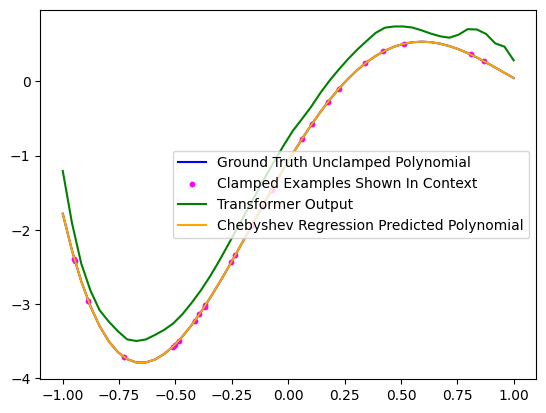

In [6]:
context_size = 25
num_predictions = 50

target_layer = 1
refuse_vector = diff_vectors[target_layer].squeeze(0)[-2]
#refuse_vector = refusal_vector[target_layer]


chebyshev_task = ChebyshevKernelLinearRegression(n_dims=1, batch_size=1, basis_dim=4, pool_dict=None, different_degrees=False, lowest_degree=1, highest_degree=11)
chebyshev_model = ChebyshevKernelLeastSquaresModel(basis_dim=11)
sampler = UniformSampler(n_dims=1)

predicted_ys_on_context = []
chebyshev_predicted = []

xs_context = sampler.sample_xs(context_size, 1)
xs_to_pred = torch.linspace(-1, 1, num_predictions).view(1,num_predictions,1)

ys_unclamped_context = chebyshev_task.evaluate(xs_context, noise=False, separate_noise=False).squeeze()
ys_unclamped_to_pred = chebyshev_task.evaluate(xs_to_pred, noise=False, separate_noise=False).squeeze()

ys_clamped_context = torch.clamp(ys_unclamped_context, min=None, max=0.5)
ys_clamped_to_pred = torch.clamp(ys_unclamped_to_pred, min=None, max=0.5)

xs_context = xs_context.squeeze()
xs_to_pred = xs_to_pred.squeeze()

handles = make_global_ablation_hooks(base_model, refuse_vector)
for i in range(0, num_predictions):
    xs = torch.concat((xs_context, torch.tensor([xs_to_pred[i]])))
    ys = torch.concat((ys_unclamped_context, torch.tensor([ys_unclamped_to_pred[i]])))

    xs = xs.unsqueeze(0)    
    xs = xs.unsqueeze(-1)  

    ys = ys.unsqueeze(0)

    xs = xs.to(device)
    ys = ys.to(device)

    pred = base_model(xs, ys).detach().cpu()
    predicted_ys_on_context.append(pred.squeeze()[-1])

    chebyshev_pred = chebyshev_model(xs,ys)
    chebyshev_predicted.append(chebyshev_pred.squeeze()[-1])

clear_hooks(handles)

plt.plot(xs_to_pred.squeeze(), ys_unclamped_to_pred.squeeze(), label="Ground Truth Unclamped Polynomial", color="blue")
plt.scatter(xs_context.squeeze(), ys_unclamped_context.squeeze(), label="Clamped Examples Shown In Context", color="fuchsia",marker='o', s=10)
plt.plot(xs_to_pred.squeeze(), predicted_ys_on_context, label="Transformer Output", color="green")
plt.plot(xs_to_pred.squeeze(), chebyshev_predicted, label="Chebyshev Regression Predicted Polynomial", color="orange")

plt.legend()

In [86]:
num_layers = 4

for i in range(num_layers):
    target_layer = i
    handles = make_global_ablation_hooks(base_model, refusal_vector[target_layer])




    clear_hooks(handles)

In [9]:
refusal_vector[0].shape

torch.Size([128])

In [39]:
ys.shape

torch.Size([1, 26])

In [4]:
x = torch.asarray([1,0.5]).view(1,2,1).to(device)
y = torch.asarray([1,2]).view(1,2,1).to(device)

In [5]:
x.shape

torch.Size([1, 2, 1])

In [6]:
torch.linspace(-1, 1, 5)

tensor([-1.0000, -0.5000,  0.0000,  0.5000,  1.0000])

In [7]:
base_model(x,y).detach().cpu()

tensor([[-0.6647, -0.2389]])